In [204]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score
from random import shuffle
import matplotlib.pyplot as plt

## Load data

In [4]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

In [8]:
# 550 data with 300 features
print(x_train.shape)

550


In [7]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [83]:
def cross_validation(x_train, y_train, k=5):
    split = []
    L = len(x_train)
    indexes = list(range(L))
    # we shuffle the data twice because only once seemed not enough
    shuffle(indexes)
    shuffle(indexes)
    # this function returns the starting position of the ith fold, it handles the case where L//k != 0
    def split_index(i):
        return(i*(L//k) + min(i,L%k))

    for i in range(k):
        validation = []
        training = []
        for index in range(L):
            # if the index is in the ith fold, it is used for validation, else for training
            if index in indexes[split_index(i):split_index(i+1)]: validation += [index]
            else: training += [index]
        split += [(np.array(training), np.array(validation))]

    return split

In [84]:
kfold_data = cross_validation(x_train, y_train, k=10)
assert len(kfold_data) == 10 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 55 # The number of data in each validation fold should equal to training data divieded by K

## example

In [58]:
from sklearn.model_selection import KFold

X = np.arange(20)
kf = KFold(n_splits=5, shuffle=True)
kfold_data= []
for i, (train_index, val_index) in enumerate(kf.split(X)):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, train_index, val_index))
    kfold_data.append([train_index, val_index])

Split: 1, Training index: [ 1  2  3  4  5  6  7  9 11 12 13 14 15 17 18 19], Validation index: [ 0  8 10 16]
Split: 2, Training index: [ 0  2  3  4  5  6  7  8  9 10 12 13 14 15 16 19], Validation index: [ 1 11 17 18]
Split: 3, Training index: [ 0  1  3  5  6  8  9 10 11 12 13 15 16 17 18 19], Validation index: [ 2  4  7 14]
Split: 4, Training index: [ 0  1  2  4  6  7  8  9 10 11 13 14 16 17 18 19], Validation index: [ 3  5 12 15]
Split: 5, Training index: [ 0  1  2  3  4  5  7  8 10 11 12 14 15 16 17 18], Validation index: [ 6  9 13 19]


In [59]:
assert len(kfold_data) == 5 # should contain 5 fold of data
assert len(kfold_data[0]) == 2 # each element should contains index of training fold and validation fold
assert kfold_data[0][1].shape[0] == 4 # The number of data in each validation fold should equal to training data divieded by K

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C”, “kernel” and “gamma” to find the best parameters by cross-validation.

In [111]:
clf = SVC(C=1.0, kernel='rbf', gamma=0.01)

In [199]:
# function to calculate accuracy of an algorithm on data
def accuracy_score(prediction, y_test):
    score = 0
    L = len(prediction)
    for i in range(L):
        if prediction[i] == y_test[i]: score +=1
    return score/L

# calculating the validation score of an algorithm using cross validation
def validation_score(clf, x_train, y_train, k):
    score = 0
    # we partition the data
    kfold_data = cross_validation(x_train, y_train, k)
    for (training_index, validation_index) in kfold_data:
        # we calculate the score for each fold
        clf.fit([x_train[i] for i in training_index], [y_train[i] for i in training_index])
        prediction = clf.predict([x_train[i] for i in validation_index])
        score += accuracy_score(prediction, [y_train[i] for i in validation_index])
    return score/k

# the grid_search function takes the cprecision, cmin, cmax, gprecision, gmin and gmax parameters in order to build the grid
def grid_search(k, x_train, y_train, cprecision, cmin, cmax, gprecision, gmin, gmax):
    best_parameters = 0, 0
    best_score = 0
    # here I use np.geomspace to distribute the parameter values on a logarithmic scale
    C_scale = np.geomspace(cmin, cmax, cprecision)
    gamma_scale = np.geomspace(gmin, gmax, gprecision)
    scores = np.zeros((gprecision, cprecision, 3))
    for i in range(gprecision):
        for j in range(cprecision):
            # For each different parameter configuration, we calculate the validation_score and store it
            gamma, C = gamma_scale[i], C_scale[j]
            clf = SVC(C=C, kernel='rbf', gamma=gamma)
            score = validation_score(clf, x_train, y_train, k)
            scores[i][j] = np.array([score, gamma, C])
            if score > best_score:
                best_parameters = gamma, C
                best_score = score
    return (best_parameters, best_score, scores)


best_parameters, best_score, scores = grid_search(5, x_train, y_train, 25, 0.1, 100000, 25, 0.00001, 10)



In [201]:

print(best_parameters)

(0.0005623413251903491, 17782.794100389227)


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like the reference image ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

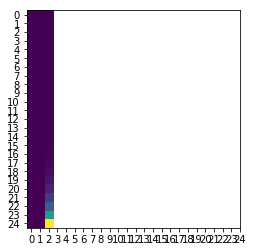

In [210]:
fig, ax = plt.subplots()
im = ax.imshow(scores[:][:][0])

ax.set_xticks(np.arange(len(scores)))
ax.set_yticks(np.arange(len(scores[0])))



## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set. **You accuracy should over 0.85**

In [202]:
gamma, C = best_parameters
best_model = SVC(C=C, kernel="rbf", gamma=gamma)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))

Accuracy score:  0.9010416666666666


## Question 5
Compare the performance of each model you have implemented from HW1

### HW1

In [41]:
train_df = pd.read_csv("../HW1/train_data.csv")
x_train = train_df['x_train'].to_numpy().reshape(-1,1)
y_train = train_df['y_train'].to_numpy().reshape(-1,1)

test_df = pd.read_csv("../HW1/test_data.csv")
x_test = test_df['x_test'].to_numpy().reshape(-1,1)
y_test = test_df['y_test'].to_numpy().reshape(-1,1)

In [42]:
print("Square error of Linear regression: ")
print("Square error of SVM regresssion model: ")

Square error of Linear regression: 
Square error of SVM regresssion model: 
